In [582]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import csv
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression


In [583]:
df_hospital=pd.read_csv("processed_data/dublinbikes_james_hospital.csv")
df_portobello=pd.read_csv("processed_data/dublinbikes_portobello.csv")

Lets get some basic features like day of week, weekend, time

In [584]:
def get_basic_features(df:pd.DataFrame):
    df["TIME"]=pd.to_datetime(df["TIME"])
    df["DAY OF WEEK"]=df["TIME"].dt.dayofweek-1
    df["HOUR"]=df["TIME"].dt.strftime("%H").astype(int)
    df["MINUTE"]=df["TIME"].dt.strftime("%M").astype(int)

    return df

In [585]:
df_hospital_map={}
df_portobello_map={}

Lets add some more complex features using weekly, daily and short-term seasonality trends in the data

For short term trends lets use intervals of 15 min, and get the last three intervals

In [586]:
def get_trend_features(df:pd.DataFrame):
    df["CURRENT AVAILABILITY"] = df["AVAILABLE BIKES"]
    df["10MIN AGO"] = df["AVAILABLE BIKES"].shift(2)
    df["20MIN AGO"] = df["AVAILABLE BIKES"].shift(4)
    df["30MIN AGO"] = df["AVAILABLE BIKES"].shift(6)
    
    df.dropna(inplace=True)
    return df

In [587]:
def shift_target_variable(df:pd.DataFrame, prediction_time : int):
    df=df.copy(deep=True)
    prediction_int = np.trunc(prediction_time/5) 
    prediction_int=prediction_int.astype(int)
    df["CURRENT AVAILABILITY"]=df["CURRENT AVAILABILITY"].shift(prediction_int)
    df["10MIN AGO"]=df["10MIN AGO"].shift(prediction_int)
    df["20MIN AGO"]=df["20MIN AGO"].shift(prediction_int)
    df["30MIN AGO"] = df["30MIN AGO"].shift(prediction_int)
    df.dropna(inplace=True)
    df.drop("WEEKEND",inplace=True,axis=1)
    return df

In [588]:
def get_seasonal_features(df:pd.DataFrame):

    df["ONE WEEKDAY AGO"] = df.loc[df["WEEKEND"]==False]["AVAILABLE BIKES"].shift(12*24).dropna()
    df["ONE WEEKDAY AGO"].fillna(0,inplace=True)
    df["ONE WEEKENDDAY AGO"] = df.loc[df["WEEKEND"]==True]["AVAILABLE BIKES"].shift(12*24).dropna()
    df["ONE WEEKENDDAY AGO"].fillna(0, inplace=True)
    df["1 DAY AGO"] = df["ONE WEEKDAY AGO"] + df["ONE WEEKENDDAY AGO"]

    df["2 WEEKDAY AGO"] = df.loc[df["WEEKEND"]==False]["AVAILABLE BIKES"].shift(12*24*2).dropna()
    df["2 WEEKDAY AGO"].fillna(0,inplace=True)
    df["2 WEEKENDDAY AGO"] = df.loc[df["WEEKEND"]==True]["AVAILABLE BIKES"].shift(12*24*2).dropna()
    df["2 WEEKENDDAY AGO"].fillna(0, inplace=True)
    
    df["2 DAYS AGO"] = df["2 WEEKDAY AGO"] + df["2 WEEKENDDAY AGO"]

    df.drop(["2 WEEKENDDAY AGO","2 WEEKDAY AGO","ONE WEEKDAY AGO","ONE WEEKENDDAY AGO"],inplace=True,axis=1)

    df["1 WEEK AGO"] = df["AVAILABLE BIKES"].shift(12*24*7)

    df.dropna(inplace=True)
    return df

In [589]:
def normalize_features(df:pd.DataFrame):
    df["AVAILABLE BIKES"] = df["AVAILABLE BIKES"]/df["BIKE STANDS"]
    """df["DAY OF WEEK"] = df["DAY OF WEEK"] / 6
    df["HOUR"] = df["HOUR"] / max(df["HOUR"])
    df["MINUTE"] = df["MINUTE"] / max(df["MINUTE"])"""
    return df

In [590]:
def calc_weekend_column(df):
    df["TIME"]=pd.to_datetime(df["TIME"])
    df["WEEKEND"] = df["TIME"].dt.dayofweek >=5
    return df


In [591]:

calc_weekend_column(df_hospital)
calc_weekend_column(df_portobello)

df_hospital.set_index("TIME",inplace=True,drop=True)
df_portobello.set_index("TIME",inplace=True,drop=True)


df_hospital=normalize_features(df_hospital)
df_portobello=normalize_features(df_portobello)


df_hospital=get_trend_features(df_hospital)
df_portobello=get_trend_features(df_portobello)


keys = ["10MIN","30MIN","60MIN"]
for key in keys:
    df_hospital_map[key] = get_seasonal_features(df_hospital)
    df_portobello_map[key] = get_seasonal_features(df_portobello)



df_hospital_map["10MIN"]=shift_target_variable(df_hospital_map["10MIN"], prediction_time = 10)
df_portobello_map["10MIN"]=shift_target_variable(df_portobello_map["10MIN"], prediction_time = 10)

df_hospital_map["30MIN"]=shift_target_variable(df_hospital_map["30MIN"], prediction_time = 30)
df_portobello_map["30MIN"]=shift_target_variable(df_portobello_map["30MIN"], prediction_time = 30)

df_hospital_map["60MIN"]=shift_target_variable(df_hospital_map["60MIN"], prediction_time = 60)
df_portobello_map["60MIN"]=shift_target_variable(df_portobello_map["60MIN"], prediction_time =  60)


"""df_hospital_map["30MIN"] = df_hospital_map["30MIN"].iloc[:-4]
df_portobello_map["30MIN"]= df_portobello_map["30MIN"].iloc[:-4]
df_hospital_map["10MIN"] = df_hospital_map["10MIN"].iloc[:-8]
df_portobello_map["10MIN"]= df_portobello_map["10MIN"].iloc[:-8]"""



'df_hospital_map["30MIN"] = df_hospital_map["30MIN"].iloc[:-4]\ndf_portobello_map["30MIN"]= df_portobello_map["30MIN"].iloc[:-4]\ndf_hospital_map["10MIN"] = df_hospital_map["10MIN"].iloc[:-8]\ndf_portobello_map["10MIN"]= df_portobello_map["10MIN"].iloc[:-8]'

In [592]:
def get_X_and_y(df:map):
    X={}
    y={}
    y["10MIN"]=df["10MIN"]["AVAILABLE BIKES"]
    X["10MIN"] = df["10MIN"].drop(axis=1,columns=["BIKE STANDS","AVAILABLE BIKES"])
    y["30MIN"]=df["30MIN"]["AVAILABLE BIKES"]
    X["30MIN"] = df["30MIN"].drop(axis=1,columns=["BIKE STANDS","AVAILABLE BIKES"])
    y["60MIN"]=df["60MIN"]["AVAILABLE BIKES"]
    X["60MIN"] = df["60MIN"].drop(axis=1,columns=["BIKE STANDS","AVAILABLE BIKES"])
    return X,y

In [593]:
X_portobello,y_portobello=get_X_and_y(df_portobello_map)
X_hospital,y_hospital=get_X_and_y(df_hospital_map)


In [594]:
ridge_model_portobello = {}
ridge_model_hospital = {}

for key in X_portobello.keys():
    ridge_model_portobello[key]=Ridge().fit(X_portobello[key],y_portobello[key])
    ridge_model_hospital[key]=Ridge().fit(X_hospital[key],y_hospital[key])



In [595]:
ridge_model_hospital["60MIN"].coef_

array([ 0.92334295, -0.09084783, -0.0572237 ,  0.02944746,  0.11646299,
        0.02107307,  0.03825702])

In [596]:


hospital_features_df=pd.DataFrame({"Feature Name":ridge_model_hospital["10MIN"].feature_names_in_,
"10 Min Prediciton":ridge_model_hospital["10MIN"].coef_,
"30 Min Prediciton":ridge_model_hospital["30MIN"].coef_,
"60 Min Prediciton":ridge_model_hospital["60MIN"].coef_
})

portobello_features_df=pd.DataFrame({"Feature Name":ridge_model_hospital["10MIN"].feature_names_in_,
"10 Min Prediciton":ridge_model_portobello["10MIN"].coef_,
"30 Min Prediciton":ridge_model_portobello["30MIN"].coef_,
"60 Min Prediciton":ridge_model_portobello["60MIN"].coef_
})

hospital_features_df.set_index("Feature Name",inplace=True)
portobello_features_df.set_index("Feature Name",inplace=True)


hospital_features_df

,10 Min Prediciton,30 Min Prediciton,60 Min Prediciton
Feature Name,,,
CURRENT AVAILABILITY,1.056450,1.009794,0.923343
10MIN AGO,-0.064461,-0.078500,-0.090848
20MIN AGO,-0.022834,-0.008491,-0.057224
30MIN AGO,0.000256,-0.022531,0.029447
1 DAY AGO,0.016731,0.057667,0.116463
2 DAYS AGO,-0.000197,0.006136,0.021073
1 WEEK AGO,0.003323,0.016668,0.038257


Text(0.5, 1.0, 'St James Hospital Bike Station')

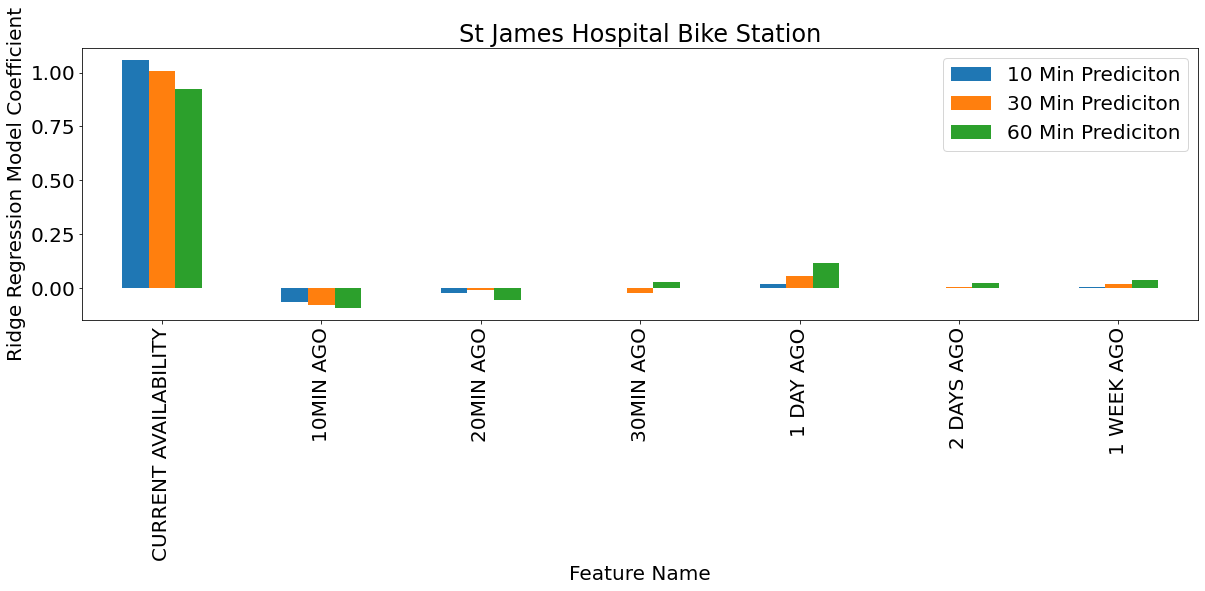

In [597]:
plt.rc('font',size=20)
hospital_features_df.plot.bar(figsize=(20,5))
plt.ylabel("Ridge Regression Model Coefficient")
plt.title("St James Hospital Bike Station")

Text(0.5, 1.0, 'Portobello Bike Station')

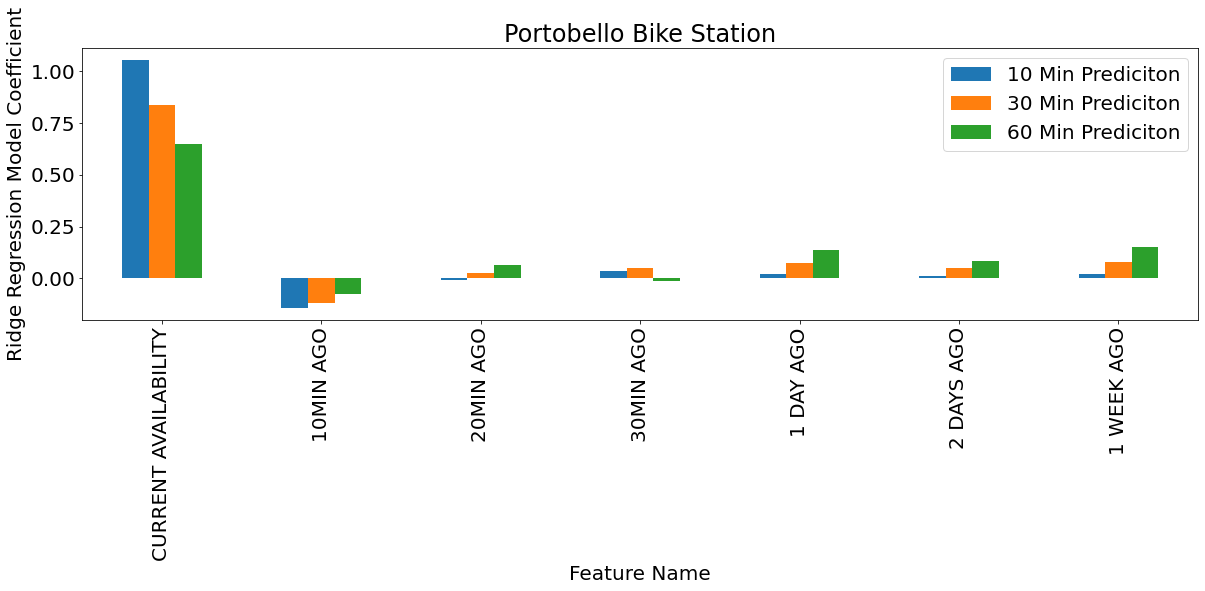

In [598]:
plt.rc('font',size=20)
portobello_features_df.plot.bar(figsize=(20,5))
plt.ylabel("Ridge Regression Model Coefficient")
plt.title("Portobello Bike Station")